In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [212]:
# loading images
device = torch.device("cpu")

IMAGE_SIZE = 128
IMAGES_PATH = Path("images")

loader = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

def load_image(name):
    img = Image.open(name)
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)



style_image = load_image(str(IMAGES_PATH / "styled.jpg"))
kandinsky_image = load_image(str(IMAGES_PATH / "kandinsky.jpg"))
berry_image = load_image(str(IMAGES_PATH / "berry.jpg"))
dog_image = load_image(str(IMAGES_PATH / "dog.jpg"))

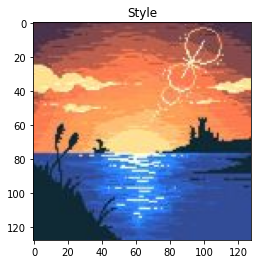

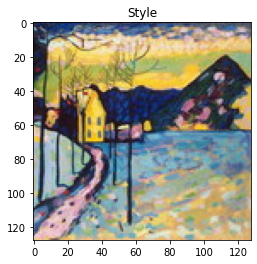

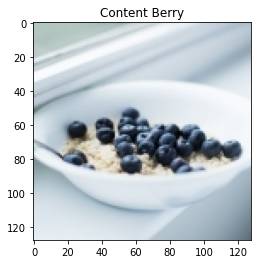

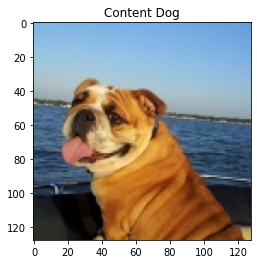

In [213]:
# showing images

to_img_transformer = transforms.ToPILImage()

def show_image(tensor, title):
    img = tensor.cpu().clone()
    img = to_img_transformer(img.squeeze(0))
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.1)

plt.figure()
show_image(style_image, title="Style")
show_image(kandinsky_image, title="Style")
show_image(berry_image, title="Content Berry")
show_image(dog_image, title="Content Dog")

In [4]:
# model import

cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/valentinnodan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [104]:
# losses

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):
    @staticmethod
    def gram_matrix(input):
        b_size, f_number, f_map_dim_x, f_map_dim_y = input.size()
        
        f = input.view(b_size * f_number, f_map_dim_x * f_map_dim_y)
        
        gram = torch.mm(f, f.t())
        
        return gram.div(b_size * f_number * f_map_dim_x * f_map_dim_y)
    
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = StyleLoss.gram_matrix(target).detach()
    
    def forward(self, input):
        gram = StyleLoss.gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target)
        return input

In [105]:
# normalization

model_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
model_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, image):
        return (image - self.mean) / self.std 

In [205]:
# get style model

content_layers_default = ['conv2d_4']
style_layers_default = ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    content_losses = []
    style_losses = []

    norm = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(norm)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
        elif isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)
    
        name = f"{layer.__class__.__name__.lower()}_{i}"
        model.add_module(f"{layer.__class__.__name__.lower()}_{i}", layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [225]:
def get_input_optimizer(input_image):
    return optim.LBFGS([input_image])

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img



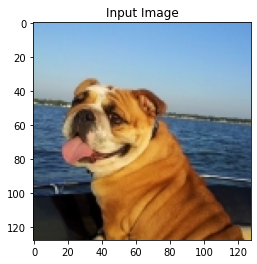

In [226]:
input_image = dog_image.clone()

plt.figure()
show_image(input_image, title="Input Image")

Building the style transfer model..


<ipython-input-105-b1f3241c99f7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-105-b1f3241c99f7>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 236.85801696777344 Content Loss: 38.669288635253906

run [100]:
Style Loss : 99.32405853271484 Content Loss: 44.87578201293945

run [150]:
Style Loss : 52.670562744140625 Content Loss: 45.436405181884766

run [200]:
Style Loss : 36.053409576416016 Content Loss: 43.99617385864258

run [250]:
Style Loss : 28.660982131958008 Content Loss: 42.40662384033203

run [300]:
Style Loss : 24.804546356201172 Content Loss: 41.054779052734375



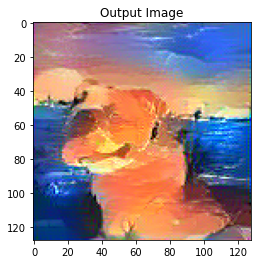

In [227]:
output = run_style_transfer(cnn, model_normalization_mean, model_normalization_std,
                            dog_image, style_image, input_image, content_weight=2)

plt.figure()
show_image(output, title='Output Image')
plt.show()

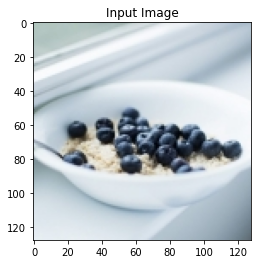

In [228]:
input_image = berry_image.clone()

plt.figure()
show_image(input_image, title="Input Image")

Building the style transfer model..


<ipython-input-105-b1f3241c99f7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-105-b1f3241c99f7>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 826.078857421875 Content Loss: 46.95964813232422

run [100]:
Style Loss : 201.34486389160156 Content Loss: 54.274505615234375

run [150]:
Style Loss : 76.60826873779297 Content Loss: 53.034934997558594

run [200]:
Style Loss : 47.440128326416016 Content Loss: 49.90702438354492

run [250]:
Style Loss : 33.493064880371094 Content Loss: 47.48871994018555

run [300]:
Style Loss : 25.44036102294922 Content Loss: 45.6297492980957



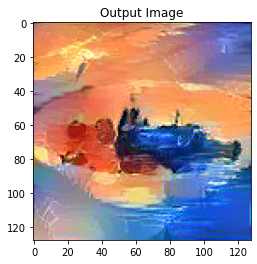

In [229]:
output = run_style_transfer(cnn, model_normalization_mean, model_normalization_std,
                            berry_image, style_image, input_image, content_weight=2)

plt.figure()
show_image(output, title='Output Image')
plt.show()

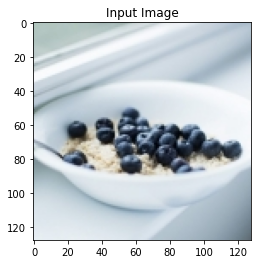

Building the style transfer model..


<ipython-input-105-b1f3241c99f7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-105-b1f3241c99f7>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 471.9620056152344 Content Loss: 309.58935546875

run [100]:
Style Loss : 132.0220184326172 Content Loss: 276.7396240234375

run [150]:
Style Loss : 77.2110824584961 Content Loss: 238.92398071289062

run [200]:
Style Loss : 56.21173095703125 Content Loss: 210.32723999023438

run [250]:
Style Loss : 42.52378845214844 Content Loss: 192.36183166503906

run [300]:
Style Loss : 36.20344924926758 Content Loss: 178.20005798339844



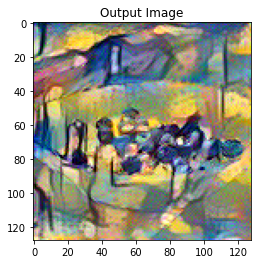

In [232]:
input_image = berry_image.clone()

plt.figure()
show_image(input_image, title="Input Image")
output = run_style_transfer(cnn, model_normalization_mean, model_normalization_std,
                            berry_image, kandinsky_image, input_image, content_weight=5)

plt.figure()
show_image(output, title='Output Image')
plt.show()